In [1]:
import sys
sys.path.append('..')

from swarm_algo.aco import AntColonyOptimizer
from search_algo.astar import AStar, TSPProblem as AStarTSPProblem
from search_algo.hill_climbing import HillClimbing, TSPProblem as HillClimbingTSPProblem
from search_algo.genetic import GeneticAlgorithm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import warnings
from typing import List, Tuple, Dict
import pandas as pd


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## 1. Tải dữ liệu kiểm tra TSP

In [2]:
import os
import glob

def load_distance_matrix(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    matrix = []
    for line in lines:
        row = [int(x) for x in line.strip().split()]
        if row:
            matrix.append(row)
    
    return np.array(matrix)

def load_optimal_solution(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    solution = []
    for line in lines:
        line = line.strip()
        if line:
            solution.append(int(line) - 1)
    
    return solution[:-1] if solution else []

def calculate_tour_distance_from_matrix(tour, distance_matrix):
    from_cities = np.array(tour)
    to_cities = np.array(tour[1:] + [tour[0]])
    return np.sum(distance_matrix[from_cities, to_cities])

def load_all_test_cases():
    test_cases = {}
    data_dir = '../data/tsp'
    
    distance_files = sorted(glob.glob(os.path.join(data_dir, '*_d.txt')))
    
    for dist_file in distance_files:
        base_name = os.path.basename(dist_file).replace('_d.txt', '')
        sol_file = dist_file.replace('_d.txt', '_s.txt')
        
        distance_matrix = load_distance_matrix(dist_file)
        optimal_solution = load_optimal_solution(sol_file) if os.path.exists(sol_file) else None
        
        if optimal_solution:
            optimal_distance = calculate_tour_distance_from_matrix(optimal_solution, distance_matrix)
        else:
            optimal_distance = None
        
        test_cases[base_name] = {
            'distance_matrix': distance_matrix,
            'optimal_solution': optimal_solution,
            'optimal_distance': optimal_distance,
            'n_cities': len(distance_matrix)
        }
    
    return test_cases

test_cases = load_all_test_cases()


## 2. Hàm chạy thuật toán

In [3]:
def run_aco(distance_matrix, num_runs=5):
    n_cities = len(distance_matrix)
    results = []
    
    for _ in range(num_runs):
        cities_coords = np.random.rand(n_cities, 2) * 100
        
        aco = AntColonyOptimizer(
            colony=cities_coords,
            num_ant=20,
            iter=100,
            alpha=1.0,
            beta=2.0,
            rho=0.5,
            Q=100
        )
        
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        tour, distance = aco.run(verbose=False)
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

def run_astar(distance_matrix, num_runs=1):
    n_cities = len(distance_matrix)
    results = []
    
    for _ in range(num_runs):
        cities_coords = [(0, 0) for _ in range(n_cities)]
        
        astar_problem = AStarTSPProblem(cities=cities_coords, start_city=0)
        astar_problem.distances = distance_matrix.tolist()
        astar_solver = AStar(problem=astar_problem, verbose=False)
        
        start_time = time.time()
        try:
            astar_path, astar_distance = astar_solver.solve()
            elapsed_time = time.time() - start_time
            
            if astar_path is not None:
                astar_tour = [state[0] for state in astar_path[:-1]]
                results.append({
                    'tour': astar_tour,
                    'distance': astar_distance,
                    'time': elapsed_time
                })
            else:
                results.append({
                    'tour': None,
                    'distance': float('inf'),
                    'time': elapsed_time
                })
        except Exception as e:
            elapsed_time = time.time() - start_time
            results.append({
                'tour': None,
                'distance': float('inf'),
                'time': elapsed_time
            })
    
    return results

def run_hill_climbing(distance_matrix, num_runs=5):
    results = []
    
    for _ in range(num_runs):
        hc_problem = HillClimbingTSPProblem(distance_matrix=distance_matrix)
        hc_solver = HillClimbing(problem=hc_problem, max_iters=1000, variant="steepest", verbose=False)
        
        start_time = time.time()
        tour, distance, _ = hc_solver.solve()
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

def run_genetic_algorithm(distance_matrix, num_runs=5):
    results = []
    
    for _ in range(num_runs):
        ga = TSPGeneticAlgorithm(
            cities=None,
            distance_matrix=distance_matrix,
            population_size=50,
            mutation_rate=0.1,
            elite_rate=0.2
        )
        
        start_time = time.time()
        tour, distance, _, _ = ga.run(generations=100)
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

In [4]:
class TSPGeneticAlgorithm:
    def __init__(self, cities, distance_matrix, population_size=50, mutation_rate=0.1, elite_rate=0.2):
        self.cities = cities
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.elite_rate = elite_rate
        
    def create_individual(self):
        tour = list(range(self.n_cities))
        np.random.shuffle(tour)
        return tour
    
    def calculate_fitness(self, tour):
        distance = calculate_tour_distance_from_matrix(tour, self.distance_matrix)
        return 1.0 / (1.0 + distance)
    
    def select_parents(self, population, fitness_scores):
        fitness_sum = np.sum(fitness_scores)
        selection_probs = fitness_scores / fitness_sum
        parent_indices = np.random.choice(len(population), size=2, p=selection_probs, replace=False)
        return population[parent_indices[0]], population[parent_indices[1]]
    
    def crossover(self, parent1, parent2):
        start = np.random.randint(0, self.n_cities - 1)
        end = np.random.randint(start + 1, self.n_cities)
        
        child = [-1] * self.n_cities
        child[start:end] = parent1[start:end]
        
        remaining = [city for city in parent2 if city not in child]
        idx = 0
        for i in range(self.n_cities):
            if child[i] == -1:
                child[i] = remaining[idx]
                idx += 1
        
        return child
    
    def mutate(self, tour):
        if np.random.rand() < self.mutation_rate:
            i, j = np.random.choice(self.n_cities, size=2, replace=False)
            tour[i], tour[j] = tour[j], tour[i]
        return tour
    
    def run(self, generations=100):
        population = [self.create_individual() for _ in range(self.population_size)]
        
        best_tour = None
        best_distance = float('inf')
        best_fitness_history = []
        avg_fitness_history = []
        
        for gen in range(generations):
            fitness_scores = np.array([self.calculate_fitness(ind) for ind in population])
            
            sorted_indices = np.argsort(-fitness_scores)
            population = [population[i] for i in sorted_indices]
            fitness_scores = fitness_scores[sorted_indices]
            
            current_best_tour = population[0]
            current_best_distance = calculate_tour_distance_from_matrix(current_best_tour, self.distance_matrix)
            
            if current_best_distance < best_distance:
                best_distance = current_best_distance
                best_tour = current_best_tour.copy()
            
            best_fitness_history.append(best_distance)
            avg_fitness_history.append(np.mean([calculate_tour_distance_from_matrix(t, self.distance_matrix) for t in population]))
            
            num_elites = int(self.elite_rate * self.population_size)
            next_generation = population[:num_elites]
            
            while len(next_generation) < self.population_size:
                parent1, parent2 = self.select_parents(population, fitness_scores)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                next_generation.append(child)
            
            population = next_generation
        
        return best_tour, best_distance, best_fitness_history, avg_fitness_history

## 3. Chạy tất cả thuật toán trên các bộ kiểm tra

In [5]:
all_results = {}

num_runs = 10

for test_name, test_data in test_cases.items():    
    distance_matrix = test_data['distance_matrix']
    
    all_results[test_name] = {
        'optimal_distance': test_data['optimal_distance'],
        'n_cities': test_data['n_cities']
    }
    
    print(f"  Chạy ACO ({num_runs} lần)...")
    all_results[test_name]['ACO'] = run_aco(distance_matrix, num_runs=num_runs)
    
    if test_data['n_cities'] <= 17:
        print(f"  Chạy A* ({num_runs} lần)...")
        all_results[test_name]['AStar'] = run_astar(distance_matrix, num_runs=num_runs)
    else:
        print(f"  Bỏ qua A* (quá nhiều thành phố: {test_data['n_cities']})")
        all_results[test_name]['AStar'] = []
    
    print(f"  Chạy Hill Climbing ({num_runs} lần)...")
    all_results[test_name]['HillClimbing'] = run_hill_climbing(distance_matrix, num_runs=num_runs)
    
    print(f"  Chạy Genetic Algorithm ({num_runs} lần)...")
    all_results[test_name]['GeneticAlgorithm'] = run_genetic_algorithm(distance_matrix, num_runs=num_runs)

  Chạy ACO (10 lần)...
  Chạy A* (10 lần)...
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Chạy A* (10 lần)...
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Bỏ qua A* (quá nhiều thành phố: 26)
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Bỏ qua A* (quá nhiều thành phố: 48)
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...


## 4. Tính toán thống kê (Tốt nhất, Trung bình, Tệ nhất)

In [6]:
def calculate_statistics(results_list):
    if not results_list:
        return {
            'best': float('inf'),
            'worst': float('inf'),
            'average': float('inf'),
            'std': 0,
            'avg_time': 0
        }
    
    distances = [r['distance'] for r in results_list if r['distance'] != float('inf')]
    times = [r['time'] for r in results_list]
    
    if not distances:
        return {
            'best': float('inf'),
            'worst': float('inf'),
            'average': float('inf'),
            'std': 0,
            'avg_time': np.mean(times) if times else 0
        }
    
    return {
        'best': np.min(distances),
        'worst': np.max(distances),
        'average': np.mean(distances),
        'std': np.std(distances),
        'avg_time': np.mean(times)
    }

statistics = {}

for test_name, test_results in all_results.items():
    statistics[test_name] = {
        'optimal_distance': test_results['optimal_distance'],
        'n_cities': test_results['n_cities']
    }
    
    for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
        if algo in test_results:
            statistics[test_name][algo] = calculate_statistics(test_results[algo])



for test_name in sorted(statistics.keys()):
    stats = statistics[test_name]
    
    print(f"\n{test_name} ({stats['n_cities']} thành phố) - Tối ưu: {stats['optimal_distance']}")
    print("-" * 120)
    
    data = []
    for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
        if algo in stats:
            s = stats[algo]
            gap_best = ((s['best'] - stats['optimal_distance']) / stats['optimal_distance'] * 100) if stats['optimal_distance'] else 0
            gap_avg = ((s['average'] - stats['optimal_distance']) / stats['optimal_distance'] * 100) if stats['optimal_distance'] else 0
            
            data.append({
                'Thuật toán': algo,
                'Tốt nhất': f"{s['best']:.2f}",
                'Trung bình': f"{s['average']:.2f}",
                'Tệ nhất': f"{s['worst']:.2f}",
                'Độ lệch chuẩn': f"{s['std']:.2f}",
                'Chênh lệch TB (%)': f"{gap_best:.2f}",
                'Chênh lệch TB (%)': f"{gap_avg:.2f}",
                'Thời gian TB (s)': f"{s['avg_time']:.3f}"
            })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))


p01 (15 thành phố) - Tối ưu: 291
------------------------------------------------------------------------------------------------------------------------
      Thuật toán Tốt nhất Trung bình Tệ nhất Độ lệch chuẩn Chênh lệch TB (%) Thời gian TB (s)
             ACO   291.00     291.00  291.00          0.00              0.00            0.432
           AStar   291.00     291.00  291.00          0.00              0.00            2.680
    HillClimbing   291.00     303.00  333.00         15.41              4.12            0.005
GeneticAlgorithm   291.00     310.60  345.00         21.41              6.74            0.146

p02 (17 thành phố) - Tối ưu: 2006
------------------------------------------------------------------------------------------------------------------------
      Thuật toán Tốt nhất Trung bình Tệ nhất Độ lệch chuẩn Chênh lệch TB (%) Thời gian TB (s)
             ACO  2085.00    2094.20 2149.00         19.21              4.40            0.390
           AStar  2085.00    20

## 5. Thống kê tổng hợp trên tất cả các bộ kiểm tra

In [7]:
aggregated_stats = {}

for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
    gaps_best = []
    gaps_avg = []
    gaps_worst = []
    times = []
    
    for test_name, stats in statistics.items():
        if algo in stats and stats['optimal_distance'] is not None:
            s = stats[algo]
            if s['best'] != float('inf'):
                gaps_best.append((s['best'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                gaps_avg.append((s['average'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                gaps_worst.append((s['worst'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                times.append(s['avg_time'])
    
    if gaps_best:
        aggregated_stats[algo] = {
            'gap_best_avg': np.mean(gaps_best),
            'gap_avg_avg': np.mean(gaps_avg),
            'gap_worst_avg': np.mean(gaps_worst),
            'gap_best_std': np.std(gaps_best),
            'gap_avg_std': np.std(gaps_avg),
            'gap_worst_std': np.std(gaps_worst),
            'avg_time': np.mean(times),
            'std_time': np.std(times)
        }
    else:
        aggregated_stats[algo] = None

agg_data = []
for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
    if aggregated_stats[algo] is not None:
        s = aggregated_stats[algo]
        agg_data.append({
            'Thuật toán': algo,
            'Chênh lệch TB tốt nhất (%)': f"{s['gap_best_avg']:.2f} ± {s['gap_best_std']:.2f}",
            'Chênh lệch TB trung bình (%)': f"{s['gap_avg_avg']:.2f} ± {s['gap_avg_std']:.2f}",
            'Chênh lệch TB tệ nhất (%)': f"{s['gap_worst_avg']:.2f} ± {s['gap_worst_std']:.2f}",
            'Thời gian TB (s)': f"{s['avg_time']:.3f} ± {s['std_time']:.3f}"
        })

agg_df = pd.DataFrame(agg_data)
print(agg_df.to_string(index=False))

      Thuật toán Chênh lệch TB tốt nhất (%) Chênh lệch TB trung bình (%) Chênh lệch TB tệ nhất (%) Thời gian TB (s)
             ACO                2.63 ± 2.79                  3.30 ± 3.66               4.61 ± 4.84    0.668 ± 0.336
           AStar                1.97 ± 1.97                  1.97 ± 1.97               1.97 ± 1.97   10.533 ± 7.853
    HillClimbing                1.37 ± 1.71                  4.58 ± 0.67               9.86 ± 2.92    0.076 ± 0.109
GeneticAlgorithm              29.57 ± 36.58                39.15 ± 41.47             53.90 ± 42.46    0.156 ± 0.021


## 6. Trực quan hóa thống kê

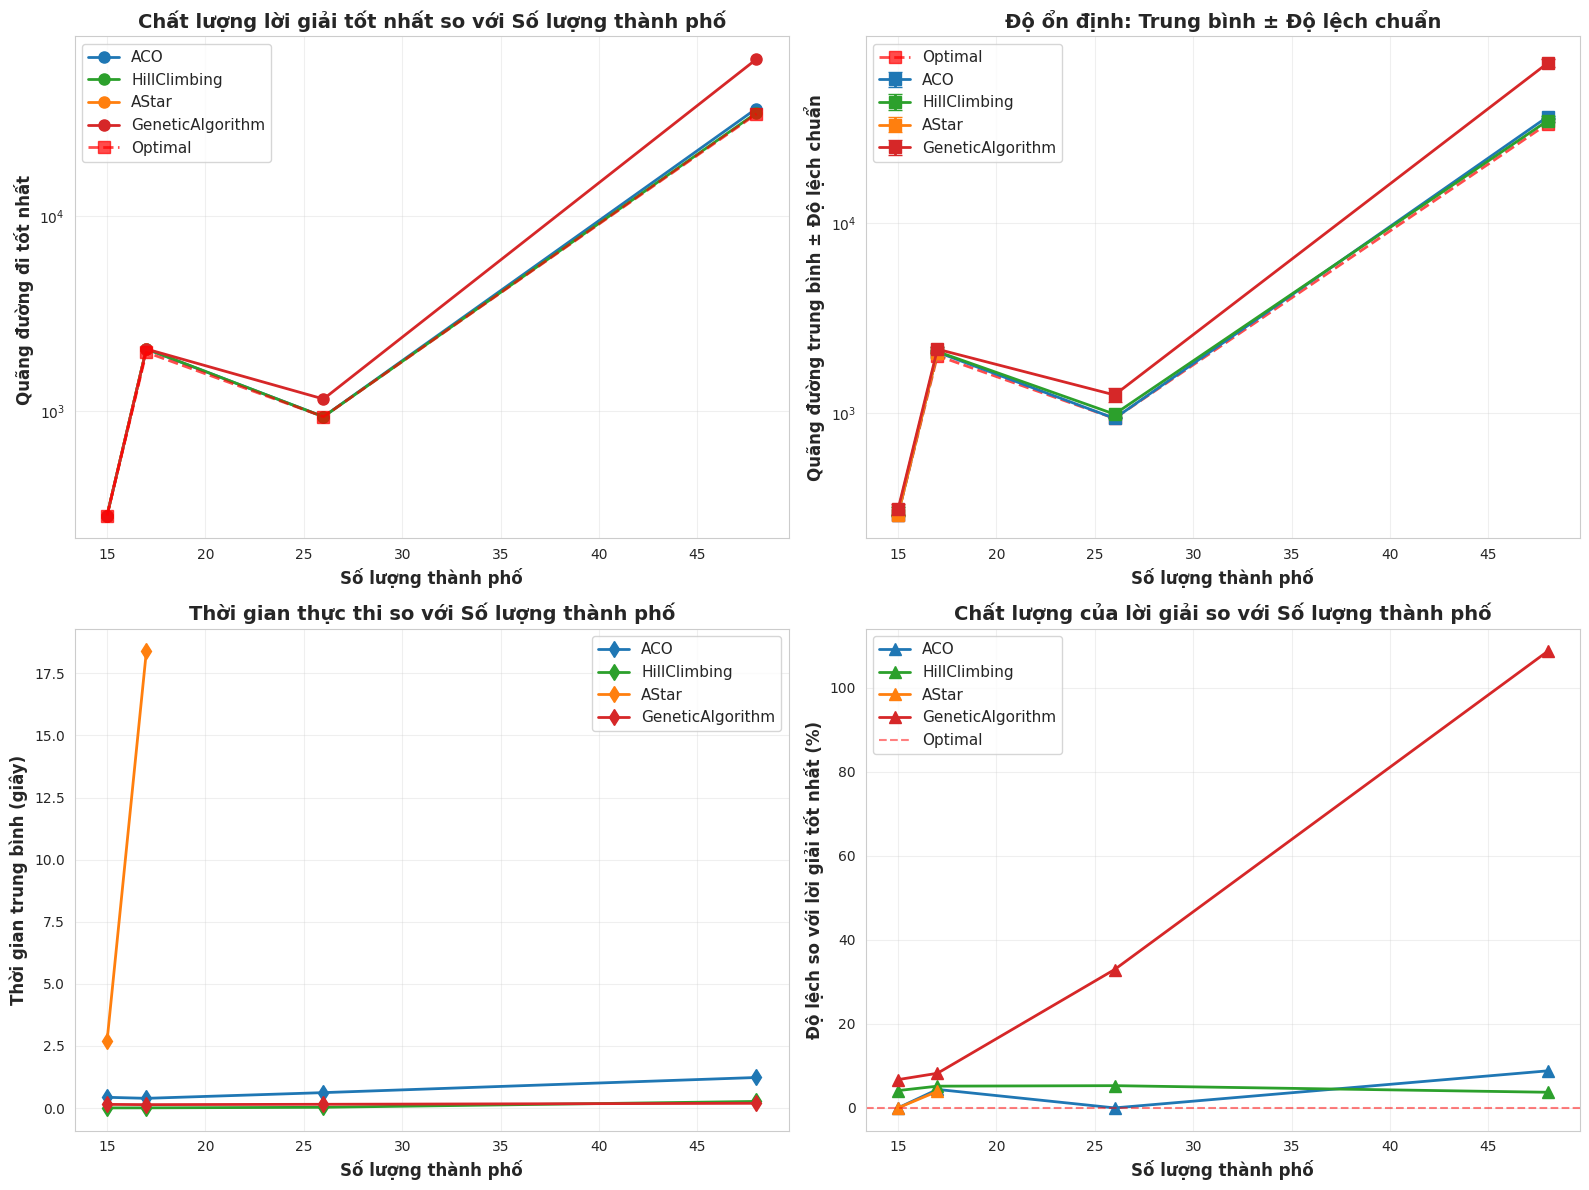

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

test_names = sorted(statistics.keys())
algorithms = ['ACO','HillClimbing', 'AStar', 'GeneticAlgorithm']
colors = {'ACO': '#1f77b4', 'AStar': '#ff7f0e', 'HillClimbing': '#2ca02c', 'GeneticAlgorithm': '#d62728'}

ax1 = axes[0, 0]
for algo in algorithms:
    best_vals = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['best'] != float('inf'):
            s = statistics[test_name][algo]
            best_vals.append(s['best'])
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    if best_vals:
        ax1.plot(problem_sizes, best_vals, marker='o', label=algo, linewidth=2, markersize=8, color=colors[algo])

optimal_vals = []
problem_sizes_opt = []
for test_name in test_names:
    if statistics[test_name]['optimal_distance']:
        optimal_vals.append(statistics[test_name]['optimal_distance'])
        problem_sizes_opt.append(statistics[test_name]['n_cities'])

ax1.plot(problem_sizes_opt, optimal_vals, marker='s', linestyle='--', color='red', 
         linewidth=2, markersize=8, label='Optimal', alpha=0.7)

ax1.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax1.set_ylabel('Quãng đường đi tốt nhất ', fontsize=12, fontweight='bold')
ax1.set_title('Chất lượng lời giải tốt nhất so với Số lượng thành phố', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

ax2 = axes[0, 1]
for algo in algorithms:
    mean_vals = []
    std_vals = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['average'] != float('inf'):
            s = statistics[test_name][algo]
            mean_vals.append(s['average'])
            std_vals.append(s['std'])
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    if mean_vals:
        ax2.errorbar(problem_sizes, mean_vals, yerr=std_vals, marker='s', label=algo, 
                    linewidth=2, markersize=8, capsize=5, color=colors[algo])

ax2.plot(problem_sizes_opt, optimal_vals, marker='s', linestyle='--', color='red', 
         linewidth=2, markersize=8, label='Optimal', alpha=0.7)

ax2.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax2.set_ylabel('Quãng đường trung bình ± Độ lệch chuẩn', fontsize=12, fontweight='bold')
ax2.set_title('Độ ổn định: Trung bình ± Độ lệch chuẩn', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

ax3 = axes[1, 0]
for algo in algorithms:
    time_vals = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['avg_time'] > 0:
            time_vals.append(statistics[test_name][algo]['avg_time'])
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    if time_vals:
        ax3.plot(problem_sizes, time_vals, marker='d', label=algo, linewidth=2, markersize=8, color=colors[algo])

ax3.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax3.set_ylabel('Thời gian trung bình (giây)', fontsize=12, fontweight='bold')
ax3.set_title('Thời gian thực thi so với Số lượng thành phố', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
for algo in algorithms:
    gaps = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['average'] != float('inf'):
            s = statistics[test_name][algo]
            if statistics[test_name]['optimal_distance']:
                gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                       statistics[test_name]['optimal_distance'] * 100)
                gaps.append(gap)
                problem_sizes.append(statistics[test_name]['n_cities'])
    
    if gaps:
        ax4.plot(problem_sizes, gaps, marker='^', label=algo, linewidth=2, markersize=8, color=colors[algo])

ax4.axhline(y=0.0, color='red', linestyle='--', alpha=0.5, label='Optimal')
ax4.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax4.set_ylabel('Độ lệch so với lời giải tốt nhất (%)', fontsize=12, fontweight='bold')
ax4.set_title('Chất lượng của lời giải so với Số lượng thành phố', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

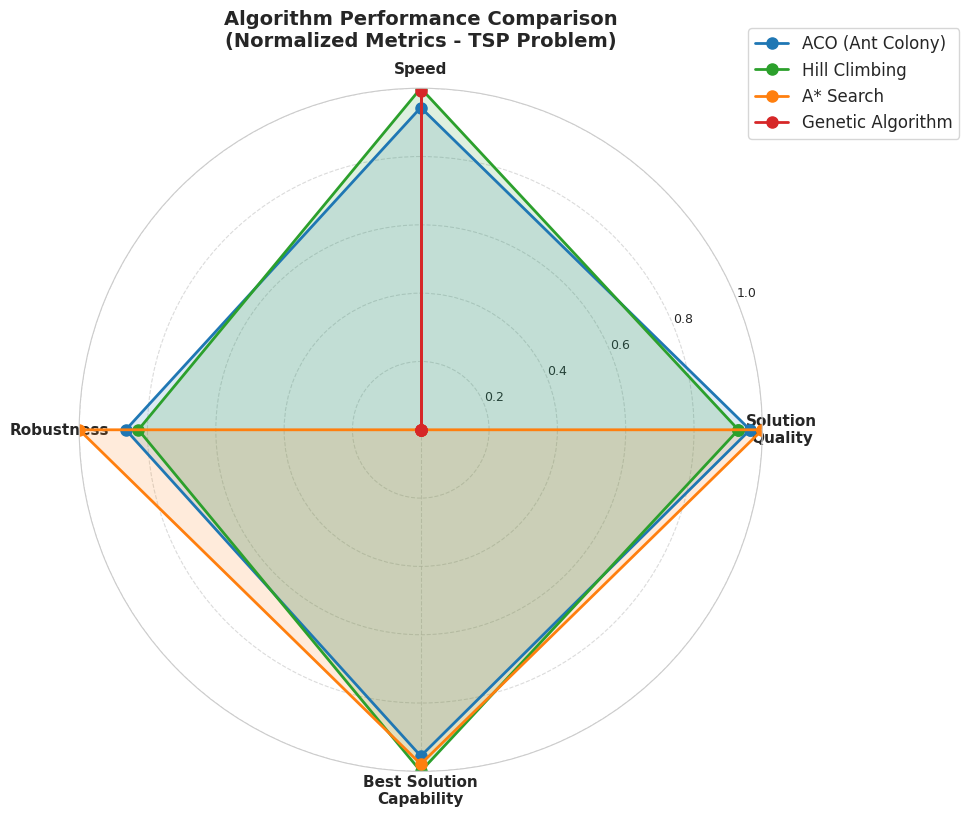


Metric Explanation:
- Solution Quality: Based on average gap from optimal (lower = better)
- Speed: Based on average execution time (faster = better)
- Robustness: Based on standard deviation (lower std = better)
- Best Solution Capability: Based on best solution gap (closer to optimal = better)

Values closer to 1.0 (outer edge) = Better performance

ALGORITHM RANKINGS (Lower rank = Better)
        Algorithm  Quality Rank  Speed Rank  Robustness Rank  Best Rank  Overall Rank
    Hill Climbing           3.0         1.0              3.0        1.0           2.0
        A* Search           1.0         4.0              1.0        2.0           2.0
 ACO (Ant Colony)           2.0         3.0              2.0        3.0           2.5
Genetic Algorithm           4.0         2.0              4.0        4.0           3.5


In [ ]:
import matplotlib.pyplot as plt
from math import pi

def normalize_metric(values, higher_is_better=True):
    """Normalize metrics for radar chart"""
    min_val, max_val = min(values), max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    normalized = [(v - min_val) / (max_val - min_val) for v in values]
    return normalized if higher_is_better else [1 - n for n in normalized]

algorithms = ['ACO', 'HillClimbing', 'AStar', 'GeneticAlgorithm']
algo_names_display = {
    'ACO': 'ACO (Ant Colony)',
    'HillClimbing': 'Hill Climbing',
    'AStar': 'A* Search', 
    'GeneticAlgorithm': 'Genetic Algorithm'
}

radar_data = []
for algo in algorithms:
    gaps_avg = []
    times = []
    stds = []
    gaps_best = []
    
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name]['optimal_distance']:
            s = statistics[test_name][algo]
            if s['average'] != float('inf'):
                gap_avg = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                          statistics[test_name]['optimal_distance'] * 100)
                gaps_avg.append(gap_avg)
                times.append(s['avg_time'])
                stds.append(s['std'])
                
                gap_best = ((s['best'] - statistics[test_name]['optimal_distance']) / 
                           statistics[test_name]['optimal_distance'] * 100)
                gaps_best.append(gap_best)
    
    if gaps_avg:
        radar_data.append({
            'algorithm': algo,
            'quality_avg': np.mean(gaps_avg),
            'speed': np.mean(times),
            'robustness': np.mean(stds),
            'best_capability': np.mean(gaps_best)
        })

all_quality = [d['quality_avg'] for d in radar_data]
all_speed = [d['speed'] for d in radar_data]
all_robustness = [d['robustness'] for d in radar_data]
all_best = [d['best_capability'] for d in radar_data]

categories = ['Solution\nQuality', 'Speed', 'Robustness', 'Best Solution\nCapability']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors_list = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  

for idx, data in enumerate(radar_data):
    algo = data['algorithm']
    
    quality_score = normalize_metric(all_quality, False)[idx]
    speed_score = normalize_metric(all_speed, False)[idx]
    robustness_score = normalize_metric(all_robustness, False)[idx]
    best_score = normalize_metric(all_best, False)[idx]
    
    values = [quality_score, speed_score, robustness_score, best_score]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=algo_names_display[algo], 
            color=colors_list[idx], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_list[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.title('Algorithm Performance Comparison\n(Normalized Metrics - TSP Problem)', 
          size=14, fontweight='bold', pad=30)

plt.tight_layout()
plt.show()
